Unzip the data

In [ ]:
import zipfile
path_to_zip_file = 'data.zip'
directory_to_extract_to = './data/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Helper functions, Quality Annotation, Peak Valley Detection, Feature computation

In [2]:
import os
import pandas as pd
from tomkin import detect_rpeak
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from outlier_calculation import Quality,compute_outlier_ecg
from joblib import Parallel,delayed
from data_quality import ECGQualityCalculation
from joblib import delayed,Parallel
from copy import deepcopy
from ecg import ecg_feature_computation
from scipy import interpolate
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
import gzip
# from peak_valley import compute_peak_valley

def get_interpolated(aclx,acly,aclz):
    time_array = aclx[:,1].reshape(-1,1)
    aclxyz = np.concatenate([time_array,time_array,time_array,time_array],axis=1)
    f = interpolate.interp1d(aclx[:,1],aclx[:,0],fill_value='extrapolate')
    aclxyz[:,1] = f(aclxyz[:,0])
    f = interpolate.interp1d(acly[:,1],acly[:,0],fill_value='extrapolate')
    aclxyz[:,2] = f(aclxyz[:,0])
    f = interpolate.interp1d(aclz[:,1],aclz[:,0],fill_value='extrapolate')
    aclxyz[:,3] = f(aclxyz[:,0])
    return aclxyz

def get_quality(data):
    outlier_threshold_high = 4000
    outlier_threshold_low = 20
    slope_threshold = 300
    eck_threshold_band_loose = 175
    eck_threshold_band_off = 20
    minimum_expected_samples = 3*(0.33)*21.33
    data_quality_band_loose = 0
    data_quality_not_worn = 0
    data_quality_band_off = 0
    data_quality_missing = 0 
    data_quality_good = 1
    acceptable_outlier_percent = 34
    
    if (len(data)== 0):
        return data_quality_band_off
    range_data = max(data)-min(data)
    if range_data<=eck_threshold_band_off:
        return data_quality_not_worn
    if (len(data)<=minimum_expected_samples) :
        return data_quality_missing
    if range_data<=eck_threshold_band_loose:
        return data_quality_band_loose
    
    outlier_counts = 0 
    for i in range(0,len(data)):
        im,ip  = i,i
        if i==0:
            im = len(data)-1
        else:
            im = i-1
        if i == len(data)-1:
            ip = 0
        else:
            ip = ip+1
        stuck = ((data[i]==data[im]) and (data[i]==data[ip]))
        flip = ((abs(data[i]-data[im])>((int(outlier_threshold_high)))) or (abs(data[i]-data[ip])>((int(outlier_threshold_high)))))
        disc = ((abs(data[i]-data[im])>((int(slope_threshold)))) and (abs(data[i]-data[ip])>((int(slope_threshold)))))
        if disc:
            outlier_counts += 1
        elif stuck:
            outlier_counts +=1
        elif flip:
            outlier_counts +=1
        elif data[i] >= outlier_threshold_high:
            outlier_counts +=1
        elif data[i]<= outlier_threshold_low:
            outlier_counts +=1
    if (100*outlier_counts>acceptable_outlier_percent*len(data)):
        return data_quality_band_loose
    return data_quality_good

def get_clean_ecg(ecg_data):
    final_data = np.zeros((0,3))
    if len(ecg_data)==0:
        return final_data
    test_object = ECGQualityCalculation()
    start_ts = ecg_data[0,0]
    final_data = np.zeros((0,3))
    while start_ts<ecg_data[-1,0]:
        index = np.where((ecg_data[:,0]>=start_ts)&(ecg_data[:,0]<start_ts+3000))[0]
        temp_data = ecg_data[index,2]
        if test_object.current_quality(temp_data)==1:
            final_data = np.concatenate((final_data,ecg_data[index,:]))
        start_ts = start_ts + 3000
    return final_data

def get_clean_rip(rip_data):
    if len(rip_data)==0:
        return final_data
    i = 0
    final_data = np.zeros((0,2))
    while i<len(rip_data):
        j = i
        index = []
        while j<len(rip_data) and rip_data[j,0] - rip_data[i,0] <= 3000:
            index.append(j)
            j+=1
        i=j+1
        temp_data = rip_data[np.array(index),1]
        if get_quality(temp_data)==1:
            final_data = np.concatenate((final_data,rip_data[np.array(index),:]))
    return final_data

def get_hr(ecg_data):
#     try:
    rpeaks = detect_rpeak(ecg_data[:,2],64)
    rpeak_ts = ecg_data[rpeaks,0]
    ecg_rr = np.zeros((len(rpeaks)-1,2))
    ecg_rr_ts = np.array(rpeak_ts)[1:]
    ecg_rr_sample = np.array(np.diff(rpeak_ts))
    index = np.where((ecg_rr_sample>=300)&(ecg_rr_sample<=2000))[0]
    ecg_rr_ts = ecg_rr_ts[index]
    ecg_rr_sam = ecg_rr_sample[index]
    rr = remove_ectopic_beats(ecg_rr_sam)
    ecg_rr_sam = ecg_rr_sam[~np.isnan(rr)]
    ecg_rr_ts = ecg_rr_ts[~np.isnan(rr)]
    outlier = compute_outlier_ecg(ecg_rr_ts/1000,ecg_rr_sam/1000)
    ind1 = []
    for ind,tup in enumerate(outlier):
        if tup[1]==Quality.ACCEPTABLE:
            ind1.append(ind)
    ind1 = np.array(ind1)
    if len(ind1)<100:
        return [],[]
    ecg_rr_ts = ecg_rr_ts[ind1]
    ecg_rr_sam = ecg_rr_sam[ind1]
    return ecg_rr_ts,ecg_rr_sam
#     except Exception as e:
#         print(e)
def get_windows(data,window_size=10,offset=10,fs=1):
    ts_array = np.arange(data[0,0],data[-1,0],offset*1000)
    window_col = []
    for t in ts_array:
        index = np.where((data[:,0]>t-window_size*1000/2)&(data[:,0]<=t+window_size*1000/2))[0]
        if len(index)<50:
            continue
        window_col.append(data[index,:])
    return window_col

def get_rip_windows(data,window_size=60,offset=10,fs=.2):
    ts_array = np.arange(data[0,0],data[-1,0],offset*1000)
    window_col = []
    for t in ts_array:
        index = np.where((data[:,0]>=t-window_size*1000/2)&(data[:,1]<=t+window_size*1000/2))[0]
        if len(index)<10:
            continue
        window_col.append(data[index,:])
    return window_col


from peak_valley import compute_peak_valley,rip_cycle_feature_computation
from scipy import stats

def get_std_chest(window,start=1,end=4):
    return np.array([np.mean(window[:,0]),np.sqrt(np.sum(np.power(np.std(window[:,start:end],axis=0),2)))])
def filter_ecg_windows(ecg_windows,acl_std):
    final_ecg_windows = []
    for window in ecg_windows:
        index = np.where((acl_std[:,0]>window[0,0])&(acl_std[:,0]<window[-1,0]))[0]
        if len(index)==0:
            continue
        window_temp = acl_std[index,1].reshape(-1)
        if len(window_temp[window_temp>.21])/len(window_temp) > .5:
            continue
        final_ecg_windows.append(window)
    return final_ecg_windows


Parse the data

In [ ]:
path = './data/'
participants = [path + f +'/' for f in os.listdir(path) if f[0]=='S']
count=0
for f in participants:
    try:
        rip = pd.read_csv(f  +'rip.txt.gz', compression='gzip',
                          sep=' ',header=None).values
        a = deepcopy(rip[:,0])
        rip[:,0] = rip[:,1]
        rip[:,1] = a
    except Exception as e:
        continue
    count+=1
    rip_data = get_clean_rip(rip)
    pickle.dump(rip_data,open(f+'rip.p','wb'))
    rip = pickle.load(open(f+'rip.p','rb'))
    
    peaks,valleys = compute_peak_valley(rip)
    print(peaks.shape,valleys.shape,peaks[:2])
    pickle.dump([peaks,valleys],open(f+'pv.p','wb'))

Standardize the features

In [3]:
from sklearn.preprocessing import StandardScaler
path = './data/'
participants = [path + f +'/' for f in os.listdir(path) if f[0]=='S']
count=0
for f in participants[::-1]: 
    if 'pv.p' not in os.listdir(f) or 'stress_marks.txt.gz' not in os.listdir(f):
        continue
    st = 0
    et = 0 
    with gzip.open(f+'stress_marks.txt.gz', 'r') as file:
        for line in file.readlines():
            line = line.decode('utf8').strip()
            parts = [x.strip() for x in line.split(',')]
            label = parts[0]
            if label[:2] in ['c1']:
                st = np.int64(parts[2])
                et = np.int64(parts[3])

    peaks,valleys = pickle.load(open(f+'pv.p','rb'))
    rip_features = rip_cycle_feature_computation(peaks,valleys)
    rip_features = rip_features[:,np.array([0,1,2,3,4,5,6,7,8,-2,-1])]
    for c in range(2,rip_features.shape[1]):
        rip_features[:,c] = StandardScaler().fit_transform(rip_features[:,c].reshape(-1,1)).reshape(-1)
        rip_features[rip_features[:,c]>5,c] = 5
        rip_features[rip_features[:,c]<-5,c] = -5
        
#         rip_features[:,c] = stats.mstats.winsorize(rip_features[:,c],limits=.01)
    rip_windows = get_rip_windows(rip_features,window_size=60,offset=30,fs=1)
    rip_features_minute = np.array([np.array([window[0,0],window[-1,1]]+
                                              list(np.mean(window[:,2:],axis=0))+
                                              list(np.std(window[:,2:],axis=0))+
                                              list(np.percentile(window[:,2:],80,axis=0))+
                                              list(np.percentile(window[:,2:],20,axis=0)))  for window 
                                              in rip_windows])
    rip_features_minute[:,2:] =StandardScaler().fit_transform(rip_features_minute[:,2:])
    print(rip_features_minute.shape)
    pickle.dump(rip_features_minute,open(f+'features_rip2.p','wb'))

(209, 38)
(250, 38)
(229, 38)
(263, 38)
(216, 38)
(256, 38)
(271, 38)
(201, 38)
(269, 38)
(255, 38)
(259, 38)
(293, 38)
(264, 38)
(233, 38)
(274, 38)
(255, 38)
(306, 38)
(240, 38)
(256, 38)
(255, 38)


(array([2.224e+03, 1.110e+02, 1.700e+01, 1.200e+01, 4.000e+00, 3.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 4.000e+00]),
 array([-0.29526691,  0.23425978,  0.76378647,  1.29331316,  1.82283985,
         2.35236654,  2.88189324,  3.41141993,  3.94094662,  4.47047331,
         5.        ]),
 <BarContainer object of 10 artists>)

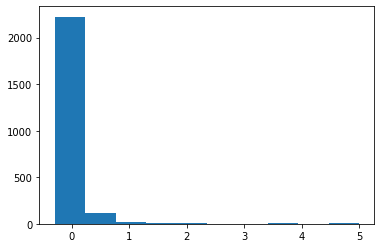

In [9]:
# plt.hist([:,10])
plt.hist(rip_features[:,5])

Annotate each feature row with stress/not stress

In [10]:
# Soujanya Chatterjee
	
# 2:06 PM (9 minutes ago)
	
# to me
import pandas as pd, numpy as np, os, csv, glob, math, matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from scipy.stats import *
import gzip
import pickle
from collections import Counter

def find_majority(k):
    myMap = {}
    maximum = ( '', 0 ) # (occurring element, occurrences)
    for n in k:
        if n in myMap: myMap[n] += 1
        else: myMap[n] = 1

        # Keep track of maximum on the go
        if myMap[n] > maximum[1]: maximum = (n,myMap[n])

    return maximum[0]

# _dir = 'W:\\Students\\cstress_features\\data\\data\\SI02\\'

def decodeLabel(label):
    label = label[:2]  # Only the first 2 characters designate the label code

    mapping = {'c1': 0, 'c2': 1, 'c3': 1, 'c4': 0, 'c5': 0, 'c6': 0, 'c7': 2}

    return mapping[label]

def readstressmarks(participantID, filename):
    features = []
    for file in os.listdir(filename):    
        if file.endswith("marks.txt.gz"):        
            with gzip.open(os.path.join(filename, file), 'r') as file:
                for line in file.readlines():
                    line = line.decode('utf8').strip()
                    parts = [x.strip() for x in line.split(',')]                    
                    label = parts[0][:2]  
                    if label not in ['c7','c6']:
                        stressClass = decodeLabel(label)
                        features.append([participantID, stressClass, int(parts[2]), int(parts[3])])
    return np.array(features)
_dirr = './data/'
parti = np.array(os.listdir(_dirr) )
header = ['participant','starttime','endtime','label'] + ['f_'+str(i) for i in range(36)]
fea_cols = ['f_'+str(i) for i in range(36)]
data = []
for p in parti:
    print(p)
    if p in ['feature.csv','feature_ecg.csv','feature_rip.csv',
             'SI09','SI23','SI24','.ipynb_checkpoints']:
        continue
    else:
        if os.path.isdir(os.path.join(_dirr,p)):
           
            _dir = (os.path.join(_dirr,p))
            gt_marks = readstressmarks(p,_dir)
            groundtruth = pd.DataFrame({'participant': gt_marks[:, 0], 'label': gt_marks[:, 1], 'starttime': gt_marks[:, 2],
                                        'endtime': gt_marks[:, 3]}, columns=['participant','label','starttime','endtime'])
            groundtruth = groundtruth.sort_values('starttime')
   
            check = False
            for file in os.listdir(_dir):    
                    if file.endswith("features_rip2.p"):                    
                        with open(_dir+'/'+file, 'rb') as f:  
                            x = pickle.load(f)
                            check  =True
            if not check:
                continue
#             print(x.shape)
#             dataset = pd.DataFrame({'starttime': x[:, 0], 'endtime': x[:, 1], 'f_1': x[:, 2]
#                                    , 'f_2': x[:, 3], 'f_3': x[:, 4], 'f_4': x[:, 5]
#                                    , 'f_5': x[:, 6], 'f_6': x[:, 7], 'f_7': x[:, 8]
#                                    , 'f_8': x[:, 9], 'f_9': x[:, 10], 'f_10': x[:, 11]
#                                    , 'f_11': x[:, 12]}, columns=['starttime','endtime','f_1','f_2','f_3','f_4','f_5','f_6','f_7','f_8',
#                                                                  'f_9','f_10','f_11'])

            dataset = pd.DataFrame(x,columns=['starttime','endtime']+['f_'+str(i) for i in range(x.shape[1]-2)])
            dataset = dataset.sort_values('starttime')

            for gt in range(len(dataset)):
                starttime = int(dataset['starttime'].iloc[gt])
                endtime = int(dataset['endtime'].iloc[gt])
                result = []
                for line in range(len(groundtruth)):
                    id, gtt, st, et = [groundtruth['participant'].iloc[line], groundtruth['label'].iloc[line], int(groundtruth['starttime'].iloc[line]),
                                      int(groundtruth['endtime'].iloc[line])]
                    if starttime < st:
                        continue
                    else:
                        if (starttime > st) and (endtime < et):
                            result.append(gtt)
                        if result:
                            fea = list(dataset[fea_cols].iloc[gt])
                            inter_data = [p, st,et,find_majority(result)],(fea)
                            flatten = lambda l: [item for sublist in l for item in sublist]

                            data.append(flatten(inter_data))

df = pd.DataFrame(data)

df.to_csv(_dirr + '/' + 'feature_rip.csv', index=False, header=header)
df.head()

.DS_Store
SI01
SI02
SI03
SI04
SI05
SI06
SI07
SI08
SI09
SI10
SI11
SI12
SI13
SI14
SI15
SI16
SI17
SI18
SI19
SI20
SI21
SI22
SI23
SI24
.ipynb_checkpoints
feature.csv
feature_rip.csv
feature_ecg.csv
feature_all.csv
feature_rip_ecg.csv
feature_ecg_norm.csv


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,SI02,1265820695499,1265820906661,0,-1.440929,1.119819,-0.654823,-1.259305,0.475557,0.117072,...,0.856622,-1.633977,0.007314,-1.719718,-1.484075,-0.445609,0.071472,-5.185084,-1.985656,-0.739230
1,SI02,1265820695499,1265820906661,0,1.552159,0.004048,1.473430,1.291964,0.579846,5.443460,...,1.119218,-1.429268,0.124058,-1.695304,-1.140569,-0.514213,0.401107,-0.976036,-2.008500,-0.664996
2,SI02,1265821586604,1265822107628,0,1.005073,-0.443625,0.670907,1.041743,1.267563,-7.097754,...,0.951957,-0.481461,-0.564165,-0.872865,0.296551,-0.822927,-5.931339,-0.046005,-0.708625,-2.299083
3,SI02,1265821586604,1265822107628,0,1.012331,0.199391,1.085841,0.072687,0.446864,-0.752681,...,0.777197,-0.744658,-0.346683,-1.039565,0.134144,-0.704391,-2.777266,-0.215215,-0.641257,-1.701984
4,SI02,1265821586604,1265822107628,0,1.734140,-0.452336,1.356260,1.181156,-1.102788,-0.501237,...,-0.530503,1.984788,0.216323,1.433857,1.637395,-0.821624,-0.395511,-0.202327,-0.297429,0.378396


Read the saved feature matrix

In [11]:
import pandas as pd
import numpy as np
feature_file = './data/feature_rip.csv'
feature = pd.read_csv(feature_file).values
y = np.int64(feature[:,3])
X = feature[:,4:]
print(X.shape,y.shape,np.sum(y),np.unique(y))
groups = feature[:,0]

(2789, 36) (2789,) 535 [0 1]


In [12]:
import matplotlib.pyplot as plt

(array([ 43., 828., 922., 547., 253., 136.,  42.,  14.,   3.,   1.]),
 array([-2.3238547666285494, -1.523975351586486, -0.7240959365444226,
        0.07578347849764056, 0.8756628935397042, 1.6755423085817678,
        2.4754217236238305, 3.275301138665894, 4.075180553707957,
        4.875059968750021, 5.674939383792085], dtype=object),
 <BarContainer object of 10 artists>)

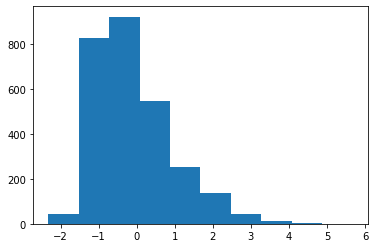

In [13]:
# X[X<=-5] = -5
# X[X>=5] = 5
plt.hist(X[:,1])

Leave one Subject Out Cross Validation

In [ ]:
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed

delta = 0.1

paramGrid = {
             'rf__kernel': ['rbf'],
             'rf__C': np.logspace(.1,4,5),
             'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-4, 4,1)],
             'rf__class_weight': [{0: w, 1: 1 - w} for w in [.4,.3,.2,.2]],
             'rf__probability':[False]
}
clf = Pipeline([('pca',StandardScaler()),('rf', SVC())])
# clf = SVC()
gkf = GroupKFold(n_splits=len(np.unique(groups)))
grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                           scoring='accuracy',verbose=5)
grid_search.fit(X,y)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
clf = grid_search.best_estimator_
clf.set_params(rf__probability=True) 
y_pred = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=-1)
print(confusion_matrix(y,y_pred),classification_report(y,y_pred))

Save the model

In [ ]:
import pickle
print(clf)
clf.fit(X,y)
# pickle.dump(clf,open('/home/jupyter/mullah/cc3/rip_model_feature_standardization.p','wb'))

pickle.dump(clf,open('/home/jupyter/mullah/apply_cstress_to_rice/models/rip_model1.p','wb'))

In [ ]:
y_pred = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),method='predict_proba',n_jobs=-1)[:,1]
# print(confusion_matrix(y,y_pred),classification_report(y,y_pred))
plt.hist(y_pred,100)
plt.show()

In [14]:
### from sklearn.decomposition import PCA
from pprint import pprint
import numpy as np
# import parfit.parfit as pf
from sklearn.base import clone, is_classifier
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
# from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,classification_report
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline
import warnings
from sklearn.model_selection import check_cv
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, ParameterGrid
from sklearn.utils.validation import _num_samples, indexable
warnings.filterwarnings('ignore')
from sklearn import metrics

def Twobias_scorer_CV(probs, y, ret_bias=False):
    db = np.transpose(np.vstack([np.array(probs).reshape(-1), np.array(y).reshape(-1)]))
    db = db[np.argsort(db[:, 0]), :]

    pos = np.sum(y == 1)
    n = len(y)
    neg = n - pos
    tp, tn = pos, 0
    lost = 0

    optbias = []
    minloss = 1

    for i in range(n):
        #		p = db[i,1]
        if db[i, 1] == 1:  # positive
            tp -= 1.0
        else:
            tn += 1.0

        # v1 = tp/pos
        #		v2 = tn/neg
        if tp / pos >= 0.95 and tn / neg >= 0.95:
            optbias = [db[i, 0], db[i, 0]]
            continue

        running_pos = pos
        running_neg = neg
        running_tp = tp
        running_tn = tn

        for j in range(i + 1, n):
            #			p1 = db[j,1]
            if db[j, 1] == 1:  # positive
                running_tp -= 1.0
                running_pos -= 1
            else:
                running_neg -= 1

            lost = (j - i) * 1.0 / n
            if running_pos == 0 or running_neg == 0:
                break

            # v1 = running_tp/running_pos
            #			v2 = running_tn/running_neg

            if running_tp / running_pos >= 0.95 and running_tn / running_neg >= 0.95 and lost < minloss:
                minloss = lost
                optbias = [db[i, 0], db[j, 0]]

    if ret_bias:
        return -minloss, optbias
    else:
        return -minloss
def cv_fit_and_score(estimator, X, y, scorer, parameters, cv):
    """Fit estimator and compute scores for a given dataset split.
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    scorer : callable
        A scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
    parameters : dict or None
        Parameters to be set on the estimator.
    cv:	Cross-validation fold indeces
    Returns
    -------
    score : float
        CV score on whole set.
    parameters : dict or None, optional
        The parameters that have been evaluated.
    """
    estimator.set_params(**parameters)
    cv_probs_ = cross_val_probs(estimator, X, y, cv)
    score = scorer(cv_probs_, y)

    return [score, parameters]  # scoring_time
    
def cross_val_probs(estimator, X, y, cv):
    probs = np.zeros(len(y))
    probs = cross_val_predict(estimator, X, y, cv=cv,method='predict_proba',n_jobs=-1)[:,1]
#     for train, test in cv:
#         temp = estimator.fit(X[train], y[train]).predict_proba(X[test])
#         probs[test] = temp[:, 1]

    return probs

def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
    
class ModifiedGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, scoring=None, fit_params=None,
                 n_jobs=1, iid=True, refit=True, cv=None, verbose=0,
                 pre_dispatch='2*n_jobs', error_score='raise'):

        super(ModifiedGridSearchCV, self).__init__(
                estimator=estimator, param_grid=param_grid, scoring=scoring,  n_jobs=n_jobs, iid=iid,
                refit=refit, cv=cv, verbose=verbose, pre_dispatch=pre_dispatch, error_score=error_score)

    def fit(self, X, y):
        """Actual fitting,  performing the search over parameters."""

        parameter_iterable = ParameterGrid(self.param_grid)

        estimator = self.estimator
        cv = self.cv

        n_samples = _num_samples(X)
        X, y = indexable(X, y)

        if y is not None:
            if len(y) != n_samples:
                raise ValueError('Target variable (y) has a different number '
                                 'of samples (%i) than data (X: %i samples)'
                                 % (len(y), n_samples))
#         cv = check_cv(cv, X, y, classifier=is_classifier(estimator))
        if self.verbose > 0:
#             if isinstance(parameter_iterable, Sized):
            n_candidates = len(parameter_iterable)
            print("Fitting {0} folds for each of {1} candidates, totalling"
                  " {2} fits".format(len(cv), n_candidates,
                                     n_candidates * len(cv)))

        base_estimator = clone(self.estimator)

        pre_dispatch = self.pre_dispatch

        out = Parallel(
                n_jobs=self.n_jobs, verbose=self.verbose,
                pre_dispatch=pre_dispatch
        )(
                delayed(cv_fit_and_score)(clone(base_estimator), X, y, self.scoring,
                                          parameters, cv=cv)
                for parameters in parameter_iterable)
#         print(out)
        best = sorted(out,key=lambda x: x[0], reverse=True)[0]
        self.best_params_ = best[1]
        self.best_score_ = best[0]

        if self.refit:
            # fit the best estimator using the entire dataset
            # clone first to work around broken estimators
            best_estimator = clone(base_estimator).set_params(
                    **best[1])
#             if y is not None:
#                 best_estimator.fit(X, y, **self.fit_params)
#             else:
#                 best_estimator.fit(X, **self.fit_params)
            self.best_estimator_ = best_estimator

        return self

/cerebralcortex/kessel_jupyter_virtualenv/cc33/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [15]:
gkf = GroupKFold(n_splits=len(np.unique(groups)))
# X1 = StandardScaler().fit_transform(X)
X1 = X
delta = 0.2
parameters1 = {'rf__kernel': ['rbf'],
              'rf__C': np.logspace(0,2,2),
              'rf__gamma': np.logspace(-9,9,10),
              'rf__class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, .50, delta)],
              'rf__probability':[True],
              'rf__verbose':[False],
              'rf__cache_size':[2000]}
parameters = {
    'rf__min_samples_leaf': [4],
    'rf__max_features': [.7,1],
    'rf__n_estimators': [100],
    'rf__n_jobs': [-1],
    'rf__criterion':['gini','entropy'],
    'rf__class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.01, .5, delta)],
    'rf__random_state': [42]
       }
svc = Pipeline([('sts',preprocessing.StandardScaler()),('rf',SVC())])
# svc = RandomForestClassifier()
# grid_search = GridSearchCV(svc,parameters, cv=gkf.split(X1,y,groups=groups), 
#              n_jobs=-1, scoring='f1', verbose=1, iid=False)
# clf = Pipeline([('sts',StandardScaler()),('clf',svc)])
grid_search = ModifiedGridSearchCV(svc, parameters1, cv=list(gkf.split(X1,y,groups=groups)),
                                   n_jobs=40, scoring=f1Bias_scorer_CV, verbose=1, iid=False)
grid_search.fit(X1,y)

Fitting 20 folds for each of 60 candidates, totalling 1200 fits


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  42 out of  60 | elapsed:  1.8min remaining:   46.2s
[Parallel(n_jobs=40)]: Done  60 out of  60 | elapsed:  2.2min finished


ModifiedGridSearchCV(cv=[(array([   0,    1,    2, ..., 2786, 2787, 2788]),
                          array([427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497...
                     param_grid={'rf__C': array([  1., 100.]),
                                 'rf__cache_size': [2000],
                                 'rf__class_weight': [{0: 0.0, 1: 1.0},
                                                      {0: 0.2, 1: 0.8},
                                                      {0: 0.4, 1: 0.6}],
                                 'rf__gamma': array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07, 1.e+09]),
                  

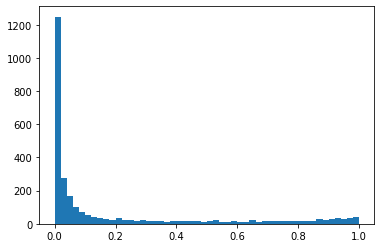

0.7776824034334765 0.3015185786630919
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2254
           1       0.72      0.85      0.78       535

    accuracy                           0.91      2789
   macro avg       0.84      0.88      0.86      2789
weighted avg       0.92      0.91      0.91      2789

[[2077  177]
 [  82  453]]
0.8032258064516129


In [16]:
clf = grid_search.best_estimator_
clf
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
clf.probability = True
CV_probs = cross_val_probs(clf, X1, y, gkf.split(X1,y,groups=groups))
import matplotlib.pyplot as plt
plt.hist(CV_probs,50)
plt.show()
# score, bias = Twobias_scorer_CV(CV_probs, y, True)
score, bias = f1Bias_scorer_CV(CV_probs, y, True)
predicted = np.asarray(CV_probs >= bias, dtype=np.int)
classified = range(n)
print(score,bias)

f = np.zeros((len(y),2))

data = pd.DataFrame()
print(metrics.classification_report(y, predicted))
print(metrics.confusion_matrix(y, predicted))

data['groups'] = groups
data['original'] = [[i] for i in y]
data['predicted'] = [[i] for i in predicted]
f_scores = []
data = data.groupby('groups').sum()
for i in range(data.shape[0]):
    f_scores.append(f1_score(data['original'][i],data['predicted'][i]))
print(np.median(f_scores))

In [17]:
clf.fit(X1,y)

pickle.dump(clf,open('/home/jupyter/mullah/apply_cstress_to_rice/models/rip_model_final.p','wb'))